In [21]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.utils import shuffle

import cv2
import albumentations as A
from albumentations.pytorch import *

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

device = 'cuda'

In [22]:
class RanaSet(Dataset):
    def __init__(self,im_folder):

        self.im_folder = im_folder
        with open('annos.json','r') as file:
            self.annos = json.load(file)
        self.annos['images'] = shuffle(self.annos['images']) 
        self.boxes = pd.read_csv('boxes.csv')

        self.transform = A.Compose([A.RandomBrightnessContrast(p=0.4,brightness_limit=0.2, contrast_limit=0.2),
                                A.SafeRotate(p=0.7,limit=15),
                                A.GaussNoise(p=0.4),
                                A.ToFloat(max_value=255),
                                ToTensorV2()], bbox_params=A.BboxParams(format='coco',label_fields=['class_labels']))


    def getImID(self,idx):
        return self.annos['images'][idx]['id']

    def getImage(self,idx):
        id = self.getImID(idx)
        filename = next(item['file_name'] for item in self.annos['images'] if item['id']==id )
        im = cv2.imread(self.im_folder + filename)
        return im
    def getAnnos(self,idx):
        id = self.getImID(idx)
        return next( item['bbox'] for item in self.annos['annotations'] if item['image_id']==id ) 

    def getBoxes(self,idx):
        id = self.getImID(idx)
        im_name = next(item['file_name'] for item in self.annos['images'] if item['id']==id )
        boxes_ = self.boxes[self.boxes['image_name']==im_name]
        boxes = boxes_.apply(lambda x: (x['bbox_x'],x['bbox_y'],x['bbox_width'],x['bbox_height']) ,axis=1).to_list()
        labels = boxes_.apply(lambda x: x['label_name'] ,axis=1).to_list()
        return boxes,labels
    
    def coco2xyxy(self,bbox):
        return (bbox[0],bbox[1],bbox[0]+bbox[2],bbox[1]+bbox[3])
    def imshow(self,im,boxes=None):
        im2show = np.transpose( 255*im.cpu().detach().numpy(), [1,2,0] ).astype(np.uint8).copy()
        if boxes is not None:
            for box in boxes:
                box = [int(x.item()) for x in box]
                p1 = (box[0],box[1])
                p2 = (box[2],box[3])
                print( p2 )
                cv2.rectangle(im2show,p1,p2,(0,0,255),1)

        cv2.imshow('im',im2show)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        # plt.imshow(im2show)
        # plt.show()
        
    def getPantalla(self,idx):
        id = self.getImID(idx)
        pantalla = next( item['bbox'] for item in ranaset.annos['annotations'] if item['image_id']==id )
        return pantalla

    def __len__(self):
        return len(self.annos['images'])

    def __getitem__(self, idx):

        if type(idx)==slice:
            start = idx.start if idx.start is not None else 0
            stop = idx.stop if idx.stop is not None else len(self.annos['images'])
            step = idx.step if idx.step is not None else 1
        elif type(idx)==int:
            start = idx
            stop = idx+1
            step = 1
        else:
            raise Exception('Error, idx debe ser int o slice')

        targets = []
        images = []
        for i in range(start, stop, step):

            # get all inputs
            im = self.getImage(i)
            boxes,labels = self.getBoxes(i)
            pantalla = self.getPantalla(i)
            boxes = boxes + [pantalla]                          # agregar pantalla
            labels = [l if l!=0 else 10 for l in labels] + [12] # 12 es la pantalla
            
            # transformar inputs
            transformed = self.transform(image=im,bboxes=boxes,class_labels=labels)             
            pantalla = next( b for b,l in zip(transformed['bboxes'],transformed['class_labels']) if l==12 )
            boxes = [self.coco2xyxy(b) for b,l in zip(transformed['bboxes'],transformed['class_labels']) if l!=12]
            labels = [l for l in transformed['class_labels'] if l!=12 ]

            # focalizar pantalla
            pantalla = [int(item) for item in pantalla]
            im = transformed['image'][:,pantalla[1]:pantalla[1]+pantalla[3],pantalla[0]:pantalla[0]+pantalla[2]]
            boxes = [ (b[0]-pantalla[0],b[1]-pantalla[1],b[2]-pantalla[0],b[3]-pantalla[1]) for b in boxes ]

            images.append(im)
            targets.append({
                'boxes':torch.tensor(boxes,dtype=torch.float32).to(device),
                'labels':torch.tensor(labels,dtype=torch.int64).to(device)
            })

        images = torch.tensor(np.array(images)).to(device)
        return images,targets

ranaset = RanaSet(im_folder='images/')

In [23]:
# ===================================================
# ===================== MODEL =======================
# ===================================================

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=11).to(device)
optimizer = torch.optim.Adam( model.parameters(),lr=0.00001 )

In [24]:
losses_train = []
losses_valid = []
train_len = 220

100%|██████████| 10/10 [08:27<00:00, 50.79s/it]


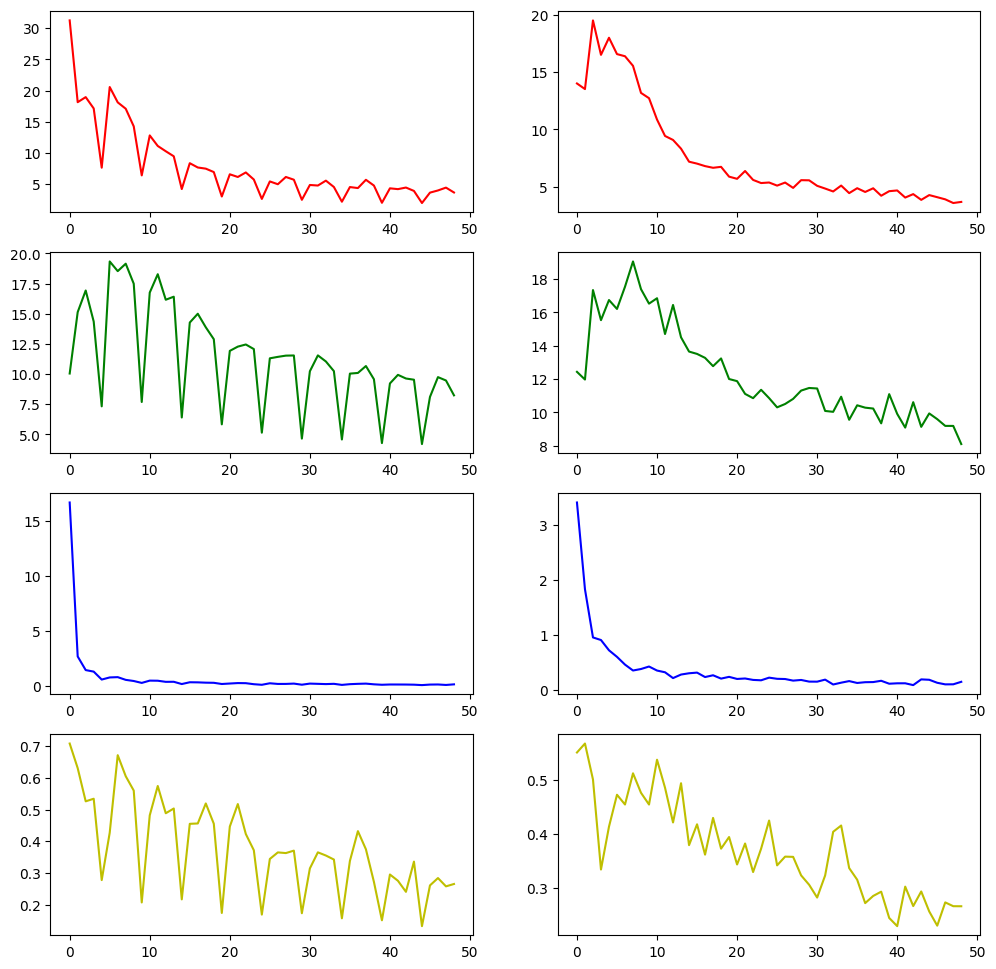

In [25]:
# ===================================================
# ================= TRAIN LOOP ======================
# ===================================================
e_loss_classifier = 0
e_loss_box_reg =    0
e_loss_objectness = 0
e_loss_rpn_box_reg =0

for e in tqdm(range(10)):
  for i in range(train_len):
      model.train()
      optimizer.zero_grad()

      # forward
      input_,target = ranaset[i]
      output = model( input_,target)

      # backward
      loss = sum( output.values() )
      loss.backward()
      optimizer.step()

      # save losses
      e_loss_classifier += output['loss_classifier'].item()
      e_loss_box_reg +=    output['loss_box_reg'].item()
      e_loss_objectness += output['loss_objectness'].item()
      e_loss_rpn_box_reg +=output['loss_rpn_box_reg'].item()

      if i%50==0 and (i!=0 or e!=0):
        losses_train.append((e_loss_classifier,e_loss_box_reg,e_loss_objectness,e_loss_rpn_box_reg))
        e_loss_classifier = 0
        e_loss_box_reg =    0
        e_loss_objectness = 0
        e_loss_rpn_box_reg =0

        # validation
        e_loss_classifier_valid = 0
        e_loss_box_reg_valid =    0
        e_loss_objectness_valid = 0
        e_loss_rpn_box_reg_valid =0
        for j in range(train_len,len(ranaset)):
          with torch.no_grad():
            input_,target = ranaset[j]
            output = model( input_,target)
            loss = sum( output.values() )
            e_loss_classifier_valid += output['loss_classifier'].item()
            e_loss_box_reg_valid +=    output['loss_box_reg'].item()
            e_loss_objectness_valid += output['loss_objectness'].item()
            e_loss_rpn_box_reg_valid +=output['loss_rpn_box_reg'].item()

        losses_valid.append((e_loss_classifier_valid,e_loss_box_reg_valid,e_loss_objectness_valid,e_loss_rpn_box_reg_valid))

        

losses_plot = np.array(losses_train)
losses_valid_plot = np.array(losses_valid)
fig,ax = plt.subplots(4,2,figsize=(12,12))
ax[0,0].plot(losses_plot[:,0],c='r')
ax[1,0].plot(losses_plot[:,1],c='g')
ax[2,0].plot(losses_plot[:,2],c='b')
ax[3,0].plot(losses_plot[:,3],c='y')

ax[0,1].plot(losses_valid_plot[:,0],c='r')
ax[1,1].plot(losses_valid_plot[:,1],c='g')
ax[2,1].plot(losses_valid_plot[:,2],c='b')
ax[3,1].plot(losses_valid_plot[:,3],c='y')
plt.show()


In [38]:
# SAVE MODEL
torch.save(model.state_dict(), 'ranavision.pt')

In [27]:
# LOAD MODEL
model.load_state_dict(torch.load('ranavision.pt', map_location=device))

In [37]:
# ===================================================
# ================== VIZUALICE ======================
# ===================================================

im,target = ranaset[218]
model.eval()
out = model(im)[0]
boxes = out['boxes']
labels = out['labels']
scores = out['scores']
pred = [ (l.item(),round(s.item(),3),b) for l,s,b in zip(labels,scores,boxes) if s.item() > 0.85]
print([ (l,s) for l,s,b in pred ])
b = [ b for l,s,b in pred ]

ranaset.imshow(im[0],b)

[(10, 0.981), (8, 0.963), (1, 0.961)]
(68, 56)
(85, 42)
(75, 45)
